In [34]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# shape file
us_shape = gpd.read_file('../../src/data/cb_2018_us_state_500k.shp')

# president voting data
us_presidency = pd.read_csv('../../src/data/president_county_candidate.csv')

# Covid data per state
df_covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

# Covid data for all of the USA
df_us_total = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv')

# Population estimates for all of the USA
state_population = pd.read_csv('../../src/data/state_population.csv')

# governers per state

url = 'https://en.wikipedia.org/wiki/List_of_current_United_States_governors'
governers_list = pd.read_html(url)
df_gov = governers_list[0]#[['State', 'Governer', 'Party.1']]
df_gov = df_gov.iloc[:,[0,2,4]]

In [3]:
us_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


# Create a column called 'percent republican' 

## The percentage of republican voters per state

In [4]:
trump_votes = us_presidency[us_presidency.candidate == 'Donald Trump'].groupby(['state']).votes.sum()
all_votes = us_presidency.groupby(['state']).votes.sum()
percent_red = trump_votes/all_votes * 100

# Normalize data by total cases in the US

In [5]:
# Normalize state covid by total us cases at that time
df_covid_total = df_covid.merge(df_us_total, left_on='date', right_on='date')
df_covid_total['cases_norm'] = df_covid_total.cases_x/df_covid_total.cases_y
df_covid_total['deaths_norm'] = df_covid_total.deaths_x/df_covid_total.deaths_y
df_covid_total_norm = df_covid_total.replace(np.nan, 0)[['date','state', 'cases_norm', 'deaths_norm']]
df_covid_total_norm

,date,state,cases_norm,deaths_norm
0,2020-01-21,Washington,1.000000,0.000000
1,2020-01-22,Washington,1.000000,0.000000
2,2020-01-23,Washington,1.000000,0.000000
3,2020-01-24,Illinois,0.500000,0.000000
4,2020-01-24,Washington,0.500000,0.000000
...,...,...,...,...
13869,2020-11-09,Virginia,0.018985,0.015550
13870,2020-11-09,Washington,0.012222,0.010793
13871,2020-11-09,West Virginia,0.002826,0.002220
13872,2020-11-09,Wisconsin,0.028107,0.010139


# Filter the month to the month of July percent cases and deaths

In [6]:
# df_covid_total.date = pd.to_datetime(df_covid_total.date)
# df_covid_total['month'] = df_covid_total.date.dt.strftime('%m')
# percent_cases_state = df_covid_total[df_covid_total.month == '07'].groupby(['state']).cases_norm.mean() * 100 
# percent_deaths_state = df_covid_total[df_covid_total.month == '07'].groupby(['state']).deaths_norm.mean() * 100 

In [7]:
# df_us_total.head()

# Pull STATE NAME and population estimates 

In [64]:
df_state_data = state_population[['STATE', 'NAME', 'POPESTIMATE2019']]
df_state_data.columns = ['fips','name', 'population']
df_state_data

,fips,name,population
0,0,United States,328239523
1,1,Alabama,4903185
2,2,Alaska,731545
3,4,Arizona,7278717
4,5,Arkansas,3017804
5,6,California,39512223
6,8,Colorado,5758736
7,9,Connecticut,3565287
8,10,Delaware,973764
9,11,District of Columbia,705749


# Create a "change in cases" column ie 'case delta'

In [9]:
# Merge total cases with united states cases 
df_covid_total = df_covid.merge(df_us_total,
                                left_on='date',
                                right_on='date',
                                suffixes=('_state', '_national'))

# convert date to datetime object
df_covid_total.date = pd.to_datetime(df_covid_total.date)

# create a months column and then take the mean
df_covid_total['month'] = df_covid_total.date.dt.strftime('%m')


# April cases
df_covid_total_april = df_covid_total[df_covid_total.month == '04']
april_cases = df_covid_total_april.groupby(['state']).cases_state.mean() / df_covid_total_april.POPEST

# July cases
df_covid_total_july = df_covid_total[df_covid_total.month == '07']
july_cases = df_covid_total_july.groupby(['state']).cases_state.mean()

# Increase in Cases
change_in_cases = july_cases - april_cases

change_in_cases
# df_covid_total['cases_state'] = cases_state
# df_covid_total['deaths_state'] = deaths_state


df_covid_pop = df_covid_total.merge(df_state_data, left_on= 'state', right_on='NAME')
df_covid_pop

,date,state,fips,cases_state,deaths_state,cases_national,deaths_national,month,STATE,NAME,POPESTIMATE2019
0,2020-01-21,Washington,53,1,0,1,0,01,53,Washington,7614893
1,2020-01-22,Washington,53,1,0,1,0,01,53,Washington,7614893
2,2020-01-23,Washington,53,1,0,1,0,01,53,Washington,7614893
3,2020-01-24,Washington,53,1,0,2,0,01,53,Washington,7614893
4,2020-01-25,Washington,53,1,0,3,0,01,53,Washington,7614893
...,...,...,...,...,...,...,...,...,...,...,...
12919,2020-11-05,West Virginia,54,26547,480,9698098,235331,11,54,West Virginia,1792147
12920,2020-11-06,West Virginia,54,27087,487,9830895,236554,11,54,West Virginia,1792147
12921,2020-11-07,West Virginia,54,27742,502,9957051,237567,11,54,West Virginia,1792147
12922,2020-11-08,West Virginia,54,28404,502,10060708,238031,11,54,West Virginia,1792147


In [10]:
df_covid_pop

,date,state,fips,cases_state,deaths_state,cases_national,deaths_national,month,STATE,NAME,POPESTIMATE2019
0,2020-01-21,Washington,53,1,0,1,0,01,53,Washington,7614893
1,2020-01-22,Washington,53,1,0,1,0,01,53,Washington,7614893
2,2020-01-23,Washington,53,1,0,1,0,01,53,Washington,7614893
3,2020-01-24,Washington,53,1,0,2,0,01,53,Washington,7614893
4,2020-01-25,Washington,53,1,0,3,0,01,53,Washington,7614893
...,...,...,...,...,...,...,...,...,...,...,...
12919,2020-11-05,West Virginia,54,26547,480,9698098,235331,11,54,West Virginia,1792147
12920,2020-11-06,West Virginia,54,27087,487,9830895,236554,11,54,West Virginia,1792147
12921,2020-11-07,West Virginia,54,27742,502,9957051,237567,11,54,West Virginia,1792147
12922,2020-11-08,West Virginia,54,28404,502,10060708,238031,11,54,West Virginia,1792147


In [11]:
# Turn state delta into a dataframe

case_delta = pd.DataFrame(change_in_cases)
case_delta.columns = ['case_delta']

In [12]:
df_covid_pop_state_delta = df_covid_pop.merge(case_delta, how='inner', on='state')

In [13]:
df_covid_pop_state_delta.columns = [x.lower() for x in df_covid_pop_state_delta.columns]

In [14]:
df_covid_pop_state_delta.iloc[:, 8]


0        53
1        53
2        53
3        53
4        53
         ..
12919    54
12920    54
12921    54
12922    54
12923    54
Name: state, Length: 12924, dtype: int64

In [15]:
columns = df_covid_pop_state_delta.columns.to_list()
columns[8] = 'drop'
df_covid_pop_state_delta.columns = columns

In [16]:
df_covid_pop_state_delta = df_covid_pop_state_delta.drop(columns=['drop', 'name'])

# Merge the the state part data on state

In [17]:
df_gov.columns = ['state', 'governer', 'party']
party = df_gov[['state', 'party']]
party.party[22] = 'Democratic'
party.party[47] = 'Republican'


/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
df_covid_pop_state_party = df_covid_pop_state_delta.merge(party, on='state')

In [19]:
us_shape.columns = [x.lower() for x in us_shape.columns]

# Merge on shape file data

In [20]:
us_shape.statefp = us_shape.statefp.astype(int)

In [21]:
us_shape.columns = [x.lower() for x in us_shape.columns]
final_shape_data = us_shape.merge(df_covid_pop_state_party, left_on='statefp', right_on='fips')


In [22]:
final_shape_data.to_pickle('../../src/data/shape_covid_pop.pickle')

In [23]:
percent_red = pd.DataFrame(percent_red)
percent_red.columns = ['percent_red']

In [24]:
final_shape_data  = final_shape_data.merge(percent_red, on='state')
final_shape_data.to_pickle('../../src/data/shape_covid_pop.pickle')

# Create a gov data frame with fip data for merging

In [97]:


final_shape_data.party = final_shape_data.party.apply(lambda x: x[0])
fib_gov_df = pd.DataFrame(final_shape_data.groupby(['fips', 'party']).cases_state.mean().index)
fib_gov_df['fips'] = fib_gov_df[0].apply(lambda x: x[0])
fib_gov_df['gov'] = fib_gov_df[0].apply(lambda x: x[1])
fip_gov_df  = fib_gov_df.iloc[:, 1:]

us_shape

(-130, -60)

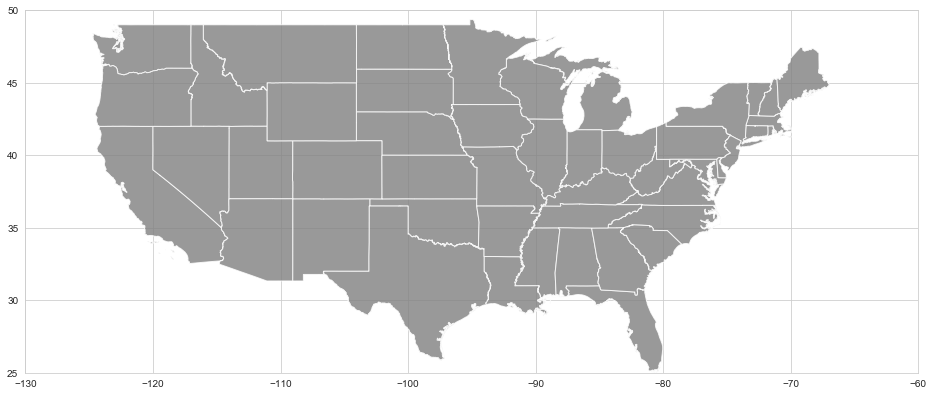

In [36]:
fig, ax = plt.subplots(figsize = (16,8))
us_shape.plot(ax=ax, alpha = 0.8, color = 'grey')

ax.set_ylim(25,50)
ax.set_xlim(-130,-60)

In [41]:
us_shape.columns

Index(['statefp', 'statens', 'affgeoid', 'geoid', 'stusps', 'name', 'lsad',
       'aland', 'awater', 'geometry'],
      dtype='object')

In [40]:
df_case_delta= df_covid_pop_state_party.groupby(['fips']).case_delta.mean().reset_index()

In [44]:
df_case_delta_shape = us_shape.merge(df_case_delta, left_on='statefp', right_on='fips')

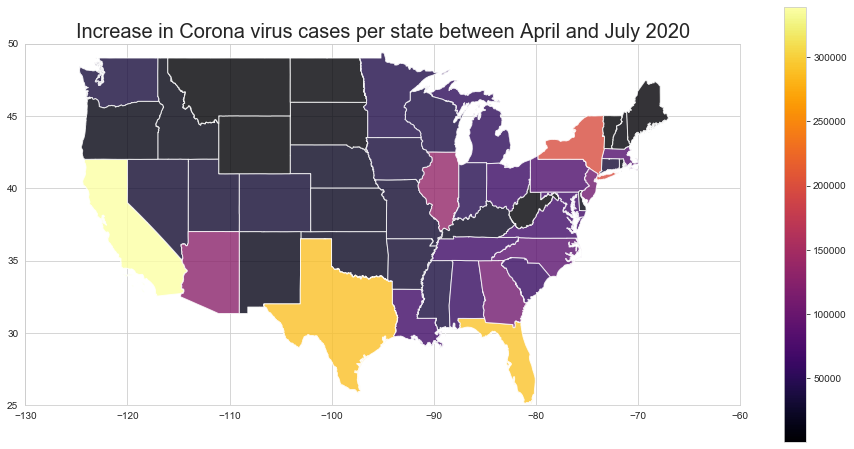

In [125]:
merged = df_case_delta_gov_shape.copy()
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

fig, ax = plt.subplots(figsize = (16,8))
merged.plot(ax=ax,
                         alpha = 0.8,
                         column='case_delta',
                         cmap = 'inferno',
                         legend=True)

ax.set_ylim(25,50)
ax.set_xlim(-130,-60)

# for idx, row in merged.iterrows():
#     plt.annotate(s=row['gov'], xy=row['coords'],horizontalalignment='center', color='white')
    
ax.set_title("Increase in Corona virus cases per state between April and July 2020", size=20);

fig.savefig('../../images/case_delta.png', bbox_inches='tight')

In [99]:
df_case_delta_gov_shape = df_case_delta_shape.merge(fip_gov_df, on='fips')

In [113]:
df_case_delta_gov_shape.geometry.centroid.coords

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


AttributeError: 'GeoSeries' object has no attribute 'coords'

In [95]:
df_case_delta_shape

,statefp,statens,affgeoid,geoid,stusps,name,lsad,aland,awater,geometry,fips,case_delta
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",28,37603.665591
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",37,88199.465591
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",40,21547.943011
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",51,67724.239785
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",54,3988.758065
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",22,66130.979570
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",26,52826.115054
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",25,80271.872043
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",16,11769.218280
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",12,292035.744086


In [96]:
fip_gov_df

,fip,gov
0,1,R
1,2,R
2,4,R
3,5,R
4,6,D
5,8,D
6,9,D
7,10,D
8,12,R
9,13,R


In [128]:
merged 
df_covid_pop_state_party[(df_covid_pop_state_party.month==4)| (df_covid_pop_state_party.month ==7)].to_csv('../../src/csv/covid_state_april2020_july2020.csv')

In [130]:
merged.to_pickle('../../src/state_shape_gov.pickle') 

In [133]:
percent_red.reset_index()

,state,percent_red
0,Alabama,62.087493
1,Alaska,61.416385
2,Arizona,48.958973
3,Arkansas,62.560794
4,California,33.388623
5,Colorado,42.080037
6,Connecticut,39.129958
7,Delaware,39.781721
8,District of Columbia,5.176033
9,Florida,51.173569


In [136]:
merged = merged.merge(percent_red.reset_index(), left_on='name', right_on='state')

In [140]:
merged = merged.drop(columns=['name','statefp'])

,statens,affgeoid,geoid,stusps,lsad,aland,awater,geometry,fips,case_delta,gov,coords,state,percent_red
0,01779790,0400000US28,28,MS,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",28,37603.665591,R,"(-89.70874723943999, 32.584967)",Mississippi,59.518282
1,01027616,0400000US37,37,NC,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",37,88199.465591,D,"(-79.46213334372521, 35.2143045)",North Carolina,50.029987
2,01102857,0400000US40,40,OK,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",40,21547.943011,R,"(-97.21718943837872, 35.31025222722655)",Oklahoma,65.373272
3,01779803,0400000US51,51,VA,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",51,67724.239785,D,"(-78.22929275106827, 38.004024)",Virginia,44.340011
4,01779805,0400000US54,54,WV,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",54,3988.758065,R,"(-80.29656250731031, 38.918831499999996)",West Virginia,68.636255
5,01629543,0400000US22,22,LA,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",22,66130.979570,D,"(-91.65450036204302, 30.974077)",Louisiana,58.467492
6,01779789,0400000US26,26,MI,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",26,52826.115054,D,"(-86.98689338967509, 46.28601410611615)",Michigan,47.862013
7,00606926,0400000US25,25,MA,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",25,80271.872043,R,"(-72.0950815055515, 42.180507563980846)",Massachusetts,32.460464
8,01779783,0400000US16,16,ID,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",16,11769.218280,R,"(-115.46340528298532, 45.49360849999999)",Idaho,63.829206
9,00294478,0400000US12,12,FL,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",12,292035.744086,R,"(-81.52179383650508, 27.949134477061747)",Florida,51.173569


In [141]:
merged.to_pickle('../../src/state_shape_gov.pickle') 